In [46]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Building the Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

# Optimizing the Hyperparameters
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional, randint

In [9]:
def load_data():
    print('Loading data...')
    loaded = np.load('data/A00-139_first_10000.npz')
    boards = loaded['arr_0']
    targets = loaded['arr_1']
    print('Data loaded.  Splitting data...')
    b_train, b_test, t_train, t_test = train_test_split(boards, targets, test_size=0.25)
    print('Returning output...')
    return b_train, b_test, t_train, t_test

In [10]:
b_train, b_test, t_train, t_test = load_data()

Loading data...
Data loaded.  Splitting data...
Returning output...


### Learning to Play Chess

The initial objective in building the model will to be teach the agent how to play chess by example.  [@oshri2016predicting] offers one method for doing this by using convolutional neural networks to make predictions about the next move based on the board position.  They did this by training seven CNNs, the predict how desirable it was for each piece to move.  The last six were trained to predict the coordinates of a probable move for each piece.  Because of the differing objectives we will need to actually split out the data set into 7 different data sets, each containing only the board positions that are relavent to that CNN.

This brings us to an important point about the CNN model.  We are not going to be giving it whole games at a time, rather pulling out only the specific board states that are relavent to that model. If we consider conceptually what this agent might be learning, because we are removing the flow of the actual game, this agent will probably not be able to reason about long term strategy very well.  Instead its creating a probability model of possible moves (and potentially impossible moves) based on a position. We might interpret this as learning the basic rules of the game, but certainly our agent isn't learning very much grant strategy.  

Long term, we will seek to combine the intuition our agent will build about chess from the CNNs along with other deep learning approaches better suited to learning strategic choices.  These later agents may very likely required the data to be formatted in a different way, but that's work for later.

#### Design Choices

##### Split by color or not
There are a series of choices that I will have to make in creating this model.  First, given that I am already cutting down the data set considerably to only moves for particular pieces, should I split the data further down to just white or black and train individual models.  This is a tough one, because there is both undeniable differences in how black has to play the game, particularly in the start of the game when they are behind a tempo automatically, and similarities in how the game is played no matter which color you are.  All that considered, the goal of *this particular model* is to learn legal and reasonable moves give a board state.  These are not the most strategic moves, as this model will have no conception of the temporal aspect of chess, and so I don't think we need to concern this model with the color of the pieces.

### Preparing the data for CNNs

In [11]:
def b_to_w(boards):
    return np.fliplr(boards)*-1

def convert_colors(b=b_train, t=t_train):
    move_made_by = t[:, 0]
    bbs = b[(move_made_by == "b")]
    bms = t[(move_made_by == 'b')]
    wbs = b[(move_made_by == "w")]
    wms = t[(move_made_by == 'w')]
    bbs_t = np.array([b_to_w(b) for b in bbs])
    bs = np.concatenate([bbs_t, wbs], axis=0)
    ms = np.concatenate([bms, wms], axis=0)
    return bs, ms

def convert_coord(a):
    #print(a)
    board = np.zeros((8, 8))
    board[int(a[0]),int(a[1])] = 1
    return board

def move_selector_data(bs, ms):
    # piece selector data consists of all available board positions. The predictor is the index of the piece
    # that moved (0 through 5).  
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=ms[:, 2:4])
    #print(y.shape)
    print("The Move Selector data set contains {} boards".format(y.shape[0]))
    return bs.astype('int'), y.reshape(y.shape[0], 64)

def single_piece_selector_data(bs, ms, piece):
    pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']
    move_selector = ms[:, 1]
    piece_bs = bs[move_selector == piece]
    piece_ms = ms[move_selector == piece, 4:6]
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=piece_ms)
    print("The {} Move Selector data set contains {} boards".format(pieces[int(piece)], piece_ms.shape[0]))
    return piece_bs.astype('int'), y.reshape(y.shape[0], 64)

In [17]:
X_train, y_train = convert_colors()
ms_X_tr, ms_y_tr = move_selector_data(X_train, y_train)
pawn_X_tr, pawn_y_tr = single_piece_selector_data(X_train, y_train, '0') 
rook_X_tr, rook_y_tr = single_piece_selector_data(X_train, y_train, '1')
knight_X_tr, knight_y_tr = single_piece_selector_data(X_train, y_train, '2')
bishop_X_tr, bishop_y_tr = single_piece_selector_data(X_train, y_train, '3')
queen_X_tr, queen_y_tr = single_piece_selector_data(X_train, y_train, '4')
king_X_tr, king_y_tr = single_piece_selector_data(X_train, y_train, '5')

The Move Selector data set contains 633586 boards
The Pawn Move Selector data set contains 166271 boards
The Rook Move Selector data set contains 109775 boards
The Knight Move Selector data set contains 111693 boards
The Bishop Move Selector data set contains 97030 boards
The Queen Move Selector data set contains 73365 boards
The King Move Selector data set contains 75452 boards


In [18]:
X_test, y_test = convert_colors(b_test, t_test)
ms_X_test, ms_y_test = move_selector_data(X_test, y_test)
pawn_X_test, pawn_y_test = single_piece_selector_data(X_test, y_test, '0') 
rook_X_test, rook_y_test = single_piece_selector_data(X_test, y_test, '1')
knight_X_test, knight_y_test = single_piece_selector_data(X_test, y_test, '2')
bishop_X_test, bishop_y_test = single_piece_selector_data(X_test, y_test, '3')
queen_X_test, queen_y_test = single_piece_selector_data(X_test, y_test, '4')
king_X_test, king_y_test = single_piece_selector_data(X_test, y_test, '5')

The Move Selector data set contains 211196 boards
The Pawn Move Selector data set contains 55653 boards
The Rook Move Selector data set contains 36430 boards
The Knight Move Selector data set contains 37030 boards
The Bishop Move Selector data set contains 32420 boards
The Queen Move Selector data set contains 24366 boards
The King Move Selector data set contains 25297 boards


In [19]:
def move_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
    input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

def compile_and_fit_ms_model(X_train, y_train, model):
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 20
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
    return model, history

def score_model(X_test, y_test, model):
    VERBOSE = 1
    score = model.evaluate(X_test, y_test, verbose=VERBOSE)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    return model, score

def plot_acc_loss(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [20]:
ms_model, ms_history = compile_and_fit_ms_model(ms_X_tr, ms_y_tr, move_selector_model())
ms_model, ms_score = score_model(ms_X_test, ms_y_test, ms_model)

Train on 506868 samples, validate on 126718 samples
Epoch 1/20
506868/506868 [==============================] - 25s - loss: 2.8080 - acc: 0.2101 - val_loss: 2.6704 - val_acc: 0.1867
Epoch 2/20
506868/506868 [==============================] - 22s - loss: 2.4083 - acc: 0.2580 - val_loss: 2.5335 - val_acc: 0.2088
Epoch 3/20
506868/506868 [==============================] - 23s - loss: 2.3169 - acc: 0.2733 - val_loss: 2.4800 - val_acc: 0.2178
Epoch 4/20
506868/506868 [==============================] - 23s - loss: 2.2604 - acc: 0.2855 - val_loss: 2.4363 - val_acc: 0.2298
Epoch 5/20
506868/506868 [==============================] - 22s - loss: 2.2209 - acc: 0.2947 - val_loss: 2.4960 - val_acc: 0.2213
Epoch 6/20
506868/506868 [==============================] - 22s - loss: 2.1939 - acc: 0.2996 - val_loss: 2.4069 - val_acc: 0.2371
Epoch 7/20
506868/506868 [==============================] - 23s - loss: 2.1730 - acc: 0.3047 - val_loss: 2.3679 - val_acc: 0.2448
Epoch 8/20
506868/506868 [============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


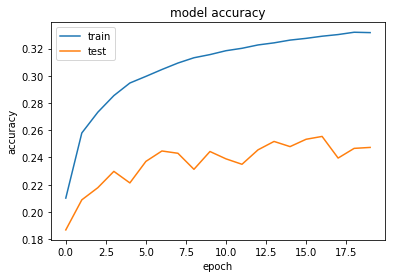

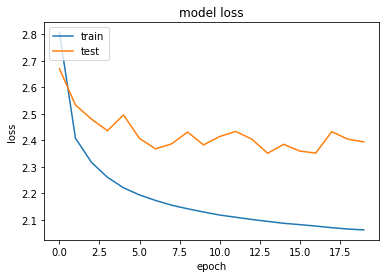

In [22]:
plot_acc_loss(ms_history)

In [23]:
def piece_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
                     input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

def compile_and_fit_ps_model(X_train, y_train, model):
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 25
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
    return model, history

In [24]:
pawn_model, pawn_history = compile_and_fit_ps_model(pawn_X_tr, pawn_y_tr, piece_selector_model())
pawn_model, pawn_score = score_model(pawn_X_test, pawn_y_test, pawn_model)

Train on 133016 samples, validate on 33255 samples
Epoch 1/25
133016/133016 [==============================] - 6s - loss: 2.7591 - acc: 0.2251 - val_loss: 2.6753 - val_acc: 0.2267
Epoch 2/25
133016/133016 [==============================] - 6s - loss: 2.3468 - acc: 0.3125 - val_loss: 2.4189 - val_acc: 0.2800
Epoch 3/25
133016/133016 [==============================] - 6s - loss: 2.1638 - acc: 0.3477 - val_loss: 2.3101 - val_acc: 0.2878
Epoch 4/25
133016/133016 [==============================] - 6s - loss: 2.0372 - acc: 0.3728 - val_loss: 2.2831 - val_acc: 0.3009
Epoch 5/25
133016/133016 [==============================] - 6s - loss: 1.9484 - acc: 0.3916 - val_loss: 2.1786 - val_acc: 0.3210
Epoch 6/25
133016/133016 [==============================] - 6s - loss: 1.8808 - acc: 0.4087 - val_loss: 2.1914 - val_acc: 0.3200
Epoch 7/25
133016/133016 [==============================] - 6s - loss: 1.8279 - acc: 0.4201 - val_loss: 2.1695 - val_acc: 0.3229
Epoch 8/25
133016/133016 [====================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


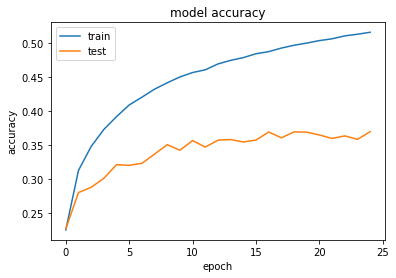

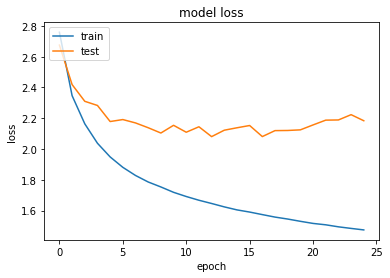

In [25]:
plot_acc_loss(pawn_history)

In [26]:
rook_model, rook_history = compile_and_fit_ps_model(rook_X_tr, rook_y_tr, piece_selector_model())
rook_model, rook_score = score_model(rook_X_test, rook_y_test, rook_model)

Train on 87820 samples, validate on 21955 samples
Epoch 1/25
87820/87820 [==============================] - 4s - loss: 3.4223 - acc: 0.1400 - val_loss: 3.2621 - val_acc: 0.1384
Epoch 2/25
87820/87820 [==============================] - 4s - loss: 2.9896 - acc: 0.1978 - val_loss: 3.1204 - val_acc: 0.1335
Epoch 3/25
87820/87820 [==============================] - 4s - loss: 2.8082 - acc: 0.2210 - val_loss: 2.9844 - val_acc: 0.1610
Epoch 4/25
87820/87820 [==============================] - 4s - loss: 2.6984 - acc: 0.2390 - val_loss: 2.9852 - val_acc: 0.1489
Epoch 5/25
87820/87820 [==============================] - 4s - loss: 2.6192 - acc: 0.2507 - val_loss: 2.8857 - val_acc: 0.1784
Epoch 6/25
87820/87820 [==============================] - 4s - loss: 2.5532 - acc: 0.2655 - val_loss: 2.8608 - val_acc: 0.1782
Epoch 7/25
87820/87820 [==============================] - 4s - loss: 2.4993 - acc: 0.2744 - val_loss: 2.8839 - val_acc: 0.1747
Epoch 8/25
87820/87820 [==============================] - 4s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


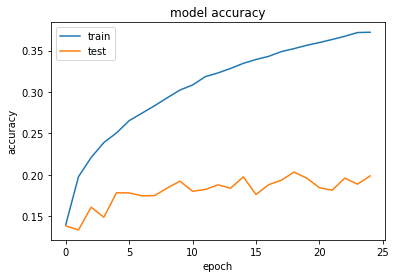

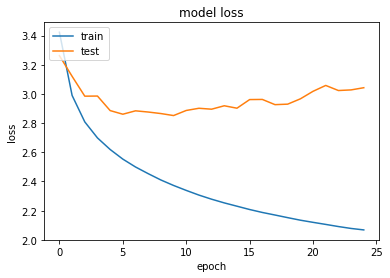

In [27]:
plot_acc_loss(rook_history)

In [30]:
knight_model, knight_history = compile_and_fit_ps_model(knight_X_tr, knight_y_tr, piece_selector_model())
knight_model, knight_score = score_model(knight_X_test, knight_y_test, knight_model)

Train on 89354 samples, validate on 22339 samples
Epoch 1/25
89354/89354 [==============================] - 4s - loss: 2.7323 - acc: 0.2844 - val_loss: 2.6147 - val_acc: 0.2489
Epoch 2/25
89354/89354 [==============================] - 4s - loss: 2.2329 - acc: 0.3708 - val_loss: 2.3165 - val_acc: 0.3228
Epoch 3/25
89354/89354 [==============================] - 4s - loss: 2.0531 - acc: 0.4004 - val_loss: 2.2840 - val_acc: 0.3162
Epoch 4/25
89354/89354 [==============================] - 4s - loss: 1.9426 - acc: 0.4217 - val_loss: 2.2245 - val_acc: 0.3343
Epoch 5/25
89354/89354 [==============================] - 4s - loss: 1.8609 - acc: 0.4385 - val_loss: 2.1859 - val_acc: 0.3470
Epoch 6/25
89354/89354 [==============================] - 4s - loss: 1.7975 - acc: 0.4532 - val_loss: 2.1849 - val_acc: 0.3422
Epoch 7/25
89354/89354 [==============================] - 3s - loss: 1.7429 - acc: 0.4670 - val_loss: 2.1495 - val_acc: 0.3578
Epoch 8/25
89354/89354 [==============================] - 4s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


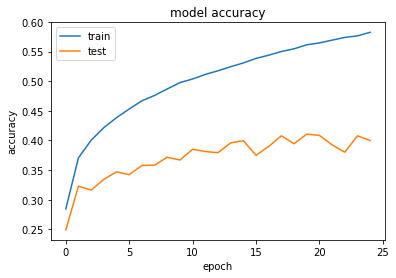

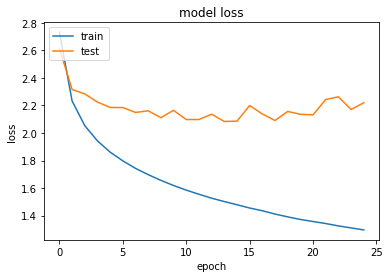

In [31]:
plot_acc_loss(knight_history)

In [32]:
bishop_model, bishop_history = compile_and_fit_ps_model(bishop_X_tr, bishop_y_tr, piece_selector_model())
bishop_model, bishop_score = score_model(bishop_X_test, bishop_y_test, bishop_model)

Train on 77624 samples, validate on 19406 samples
Epoch 1/25
77624/77624 [==============================] - 4s - loss: 3.0562 - acc: 0.2212 - val_loss: 2.9048 - val_acc: 0.2415
Epoch 2/25
77624/77624 [==============================] - 3s - loss: 2.5666 - acc: 0.3107 - val_loss: 2.7525 - val_acc: 0.2637
Epoch 3/25
77624/77624 [==============================] - 3s - loss: 2.3776 - acc: 0.3452 - val_loss: 2.6385 - val_acc: 0.2820
Epoch 4/25
77624/77624 [==============================] - 3s - loss: 2.2558 - acc: 0.3667 - val_loss: 2.6238 - val_acc: 0.2794
Epoch 5/25
77624/77624 [==============================] - 3s - loss: 2.1614 - acc: 0.3875 - val_loss: 2.5700 - val_acc: 0.2900
Epoch 6/25
77624/77624 [==============================] - 3s - loss: 2.0863 - acc: 0.4011 - val_loss: 2.5738 - val_acc: 0.2892
Epoch 7/25
77624/77624 [==============================] - 3s - loss: 2.0229 - acc: 0.4155 - val_loss: 2.5640 - val_acc: 0.2970
Epoch 8/25
77624/77624 [==============================] - 3s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


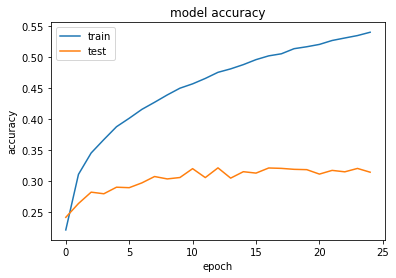

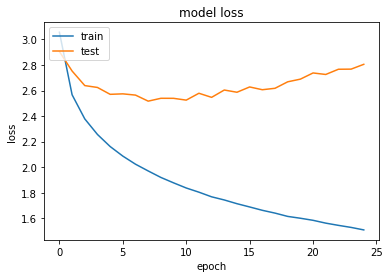

In [33]:
plot_acc_loss(bishop_history)

In [34]:
queen_model, queen_history = compile_and_fit_ps_model(queen_X_tr, queen_y_tr, piece_selector_model())
queen_model, queen_score = score_model(queen_X_test, queen_y_test, queen_model)

Train on 58692 samples, validate on 14673 samples
Epoch 1/25
58692/58692 [==============================] - 3s - loss: 3.6576 - acc: 0.1064 - val_loss: 3.5007 - val_acc: 0.1266
Epoch 2/25
58692/58692 [==============================] - 2s - loss: 3.2257 - acc: 0.1736 - val_loss: 3.3845 - val_acc: 0.1222
Epoch 3/25
58692/58692 [==============================] - 2s - loss: 3.0419 - acc: 0.2039 - val_loss: 3.2528 - val_acc: 0.1472
Epoch 4/25
58692/58692 [==============================] - 2s - loss: 2.9284 - acc: 0.2222 - val_loss: 3.1846 - val_acc: 0.1606
Epoch 5/25
58692/58692 [==============================] - 2s - loss: 2.8408 - acc: 0.2401 - val_loss: 3.1779 - val_acc: 0.1591
Epoch 6/25
58692/58692 [==============================] - 2s - loss: 2.7670 - acc: 0.2557 - val_loss: 3.1487 - val_acc: 0.1633
Epoch 7/25
58692/58692 [==============================] - 2s - loss: 2.7049 - acc: 0.2662 - val_loss: 3.0706 - val_acc: 0.1861
Epoch 8/25
58692/58692 [==============================] - 2s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


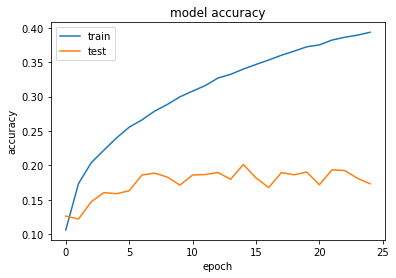

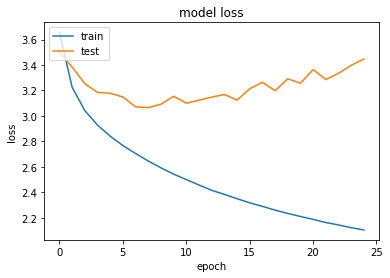

In [35]:
plot_acc_loss(queen_history)

In [36]:
king_model, king_history = compile_and_fit_ps_model(king_X_tr, king_y_tr, piece_selector_model())
king_model, king_score = score_model(king_X_test, king_y_test, king_model)

Train on 60361 samples, validate on 15091 samples
Epoch 1/25
60361/60361 [==============================] - 3s - loss: 2.6790 - acc: 0.2623 - val_loss: 2.3926 - val_acc: 0.2478
Epoch 2/25
60361/60361 [==============================] - 2s - loss: 1.9928 - acc: 0.3523 - val_loss: 2.2429 - val_acc: 0.2387
Epoch 3/25
60361/60361 [==============================] - 2s - loss: 1.8314 - acc: 0.3874 - val_loss: 2.1474 - val_acc: 0.2642
Epoch 4/25
60361/60361 [==============================] - 2s - loss: 1.7367 - acc: 0.4128 - val_loss: 2.0678 - val_acc: 0.2859
Epoch 5/25
60361/60361 [==============================] - 3s - loss: 1.6569 - acc: 0.4356 - val_loss: 2.0244 - val_acc: 0.2940
Epoch 6/25
60361/60361 [==============================] - 3s - loss: 1.5968 - acc: 0.4533 - val_loss: 2.1824 - val_acc: 0.2592
Epoch 7/25
60361/60361 [==============================] - 3s - loss: 1.5405 - acc: 0.4697 - val_loss: 2.0509 - val_acc: 0.3000
Epoch 8/25
60361/60361 [==============================] - 3s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


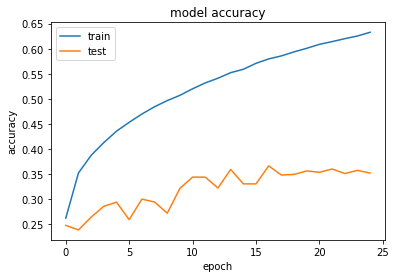

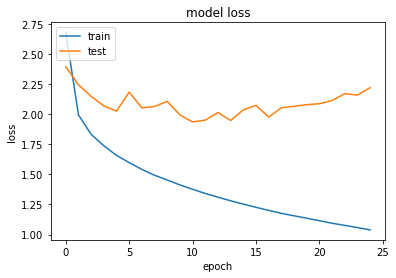

In [37]:
plot_acc_loss(king_history)

#### Results of Initial Modeling

So, I want to let the above model serve as a benchmark.  As we develop and search for the optimal model, we can our best idea above. Know that we have a benchmark, I need to search the space.  Ther Hyperas library will provide a convenient high level api for hyperparameter optimization, so I will use that.

In [62]:
def optimize_move_selector_model(X_train, y_train, X_test, y_test):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64
    
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 20
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    # network
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
    input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    conv_layers = {{randint(3)}} + 1
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    dense_layers = {{randint(3)}} + 1
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
    
    score, acc = model.evaluate(X_test, y_test, show_accuracy=True, verbose=VERBOSE)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

def data():
    return ms_X_tr, ms_y_tr, ms_X_test, ms_y_test

In [63]:
best_run, best_model = optim.minimize(model=optimize_move_selector_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='Convolutional Model')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers.convolutional import Conv2D
except:
    pass

try:
    from keras.optimizers import SGD, RMSprop, Adam
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform, conditional, randint
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'conv_layers': hp.randint('conv_layers', 3),
        'conv_layers_1': hp.randint('conv_layers_1', 3),
    }

>>> Data
1: 
2: 
3: 
4: 
>>> Resulting replaced keras model:

   1: def keras_fmin_fnct(spa

NameError: name 'kernal_size' is not defined